# Initial Preprocessing

In [1]:
from pipeline import ModelPipeline

# Run model with all features
mp = ModelPipeline("/Users/zoe_mac/Desktop/EDA/subset_transactions2.csv")

# basic cleaning & features
mp.rename_columns()
mp.drop_duplicates()
mp.check_for_null()
mp.extract_currency_features()
mp.extract_time_features()
mp.cyclical_encoding()
mp.create_unique_ids()
mp.extract_additional_time_features()

# one‑hot encode only for some cols
mp.apply_one_hot_encoding(
    onehot_categorical_features=["sent_currency", "received_currency", "payment_type"]
)

/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


# Train/Val/Test Split

In [2]:
# random_stratified or tempral
mp.split_train_test_val(split_type="temporal", test_size=0.15, val_size=0.15)

Keeping from_account_idx and to_account_idx (for merging node feats onto tabular data for Catboost)


(        day_cos       day_sin  edge_id  hour_of_day  is_weekend  \
 0          -1.0  1.224647e-16        0            0           0   
 1534       -1.0  1.224647e-16     1534            0           0   
 1533       -1.0  1.224647e-16     1533            0           0   
 1532       -1.0  1.224647e-16     1532            0           0   
 1531       -1.0  1.224647e-16     1531            0           0   
 ...         ...           ...      ...          ...         ...   
 875665     -0.5  8.660254e-01   875665           16           0   
 875664     -0.5  8.660254e-01   875664           16           0   
 875663     -0.5  8.660254e-01   875663           16           0   
 875662     -0.5  8.660254e-01   875662           16           0   
 875661     -0.5  8.660254e-01   875661           16           0   
 
         log_exchange_rate  payment_type_ACH  payment_type_Bitcoin  \
 0                0.693147               0.0                   0.0   
 1534             0.693147               0

## A check for positive rate for each class

In [3]:
# assuming y_train, y_val, y_test are your label arrays or Series
for name, y in [("Train", mp.y_train), ("Validation", mp.y_val), ("Test", mp.y_test)]:
    # if y is a pandas Series you can also do y.mean()
    pos_rate = y.sum() / len(y)
    print(f"{name} set positive rate: {pos_rate:.2%} ({y.sum()} / {len(y)})")

Train set positive rate: 0.33% (2893 / 875630)
Validation set positive rate: 0.39% (726 / 187635)
Test set positive rate: 0.83% (1558 / 187636)


# Combine Node_features & Edge Features

In [4]:
# 3) Compute node‐level graph features on each split
mp.compute_split_specific_node_features(
    graph_features=["sent_amount_usd"]
)
mp.X_train, mp.X_val, mp.X_test = mp.add_node_graph_feats_to_df()

✅ Computed node features for train with 107090 nodes.
✅ Computed node features for val with 107355 nodes.
✅ Computed node features for test with 107583 nodes.


# Check Number of Columns

In [5]:
my_cols = mp.X_train.columns.tolist()
assert(len(my_cols)==73)

# Model with All Features

[0]	validation_0-aucpr:0.37246
[100]	validation_0-aucpr:0.65798
[130]	validation_0-aucpr:0.66476


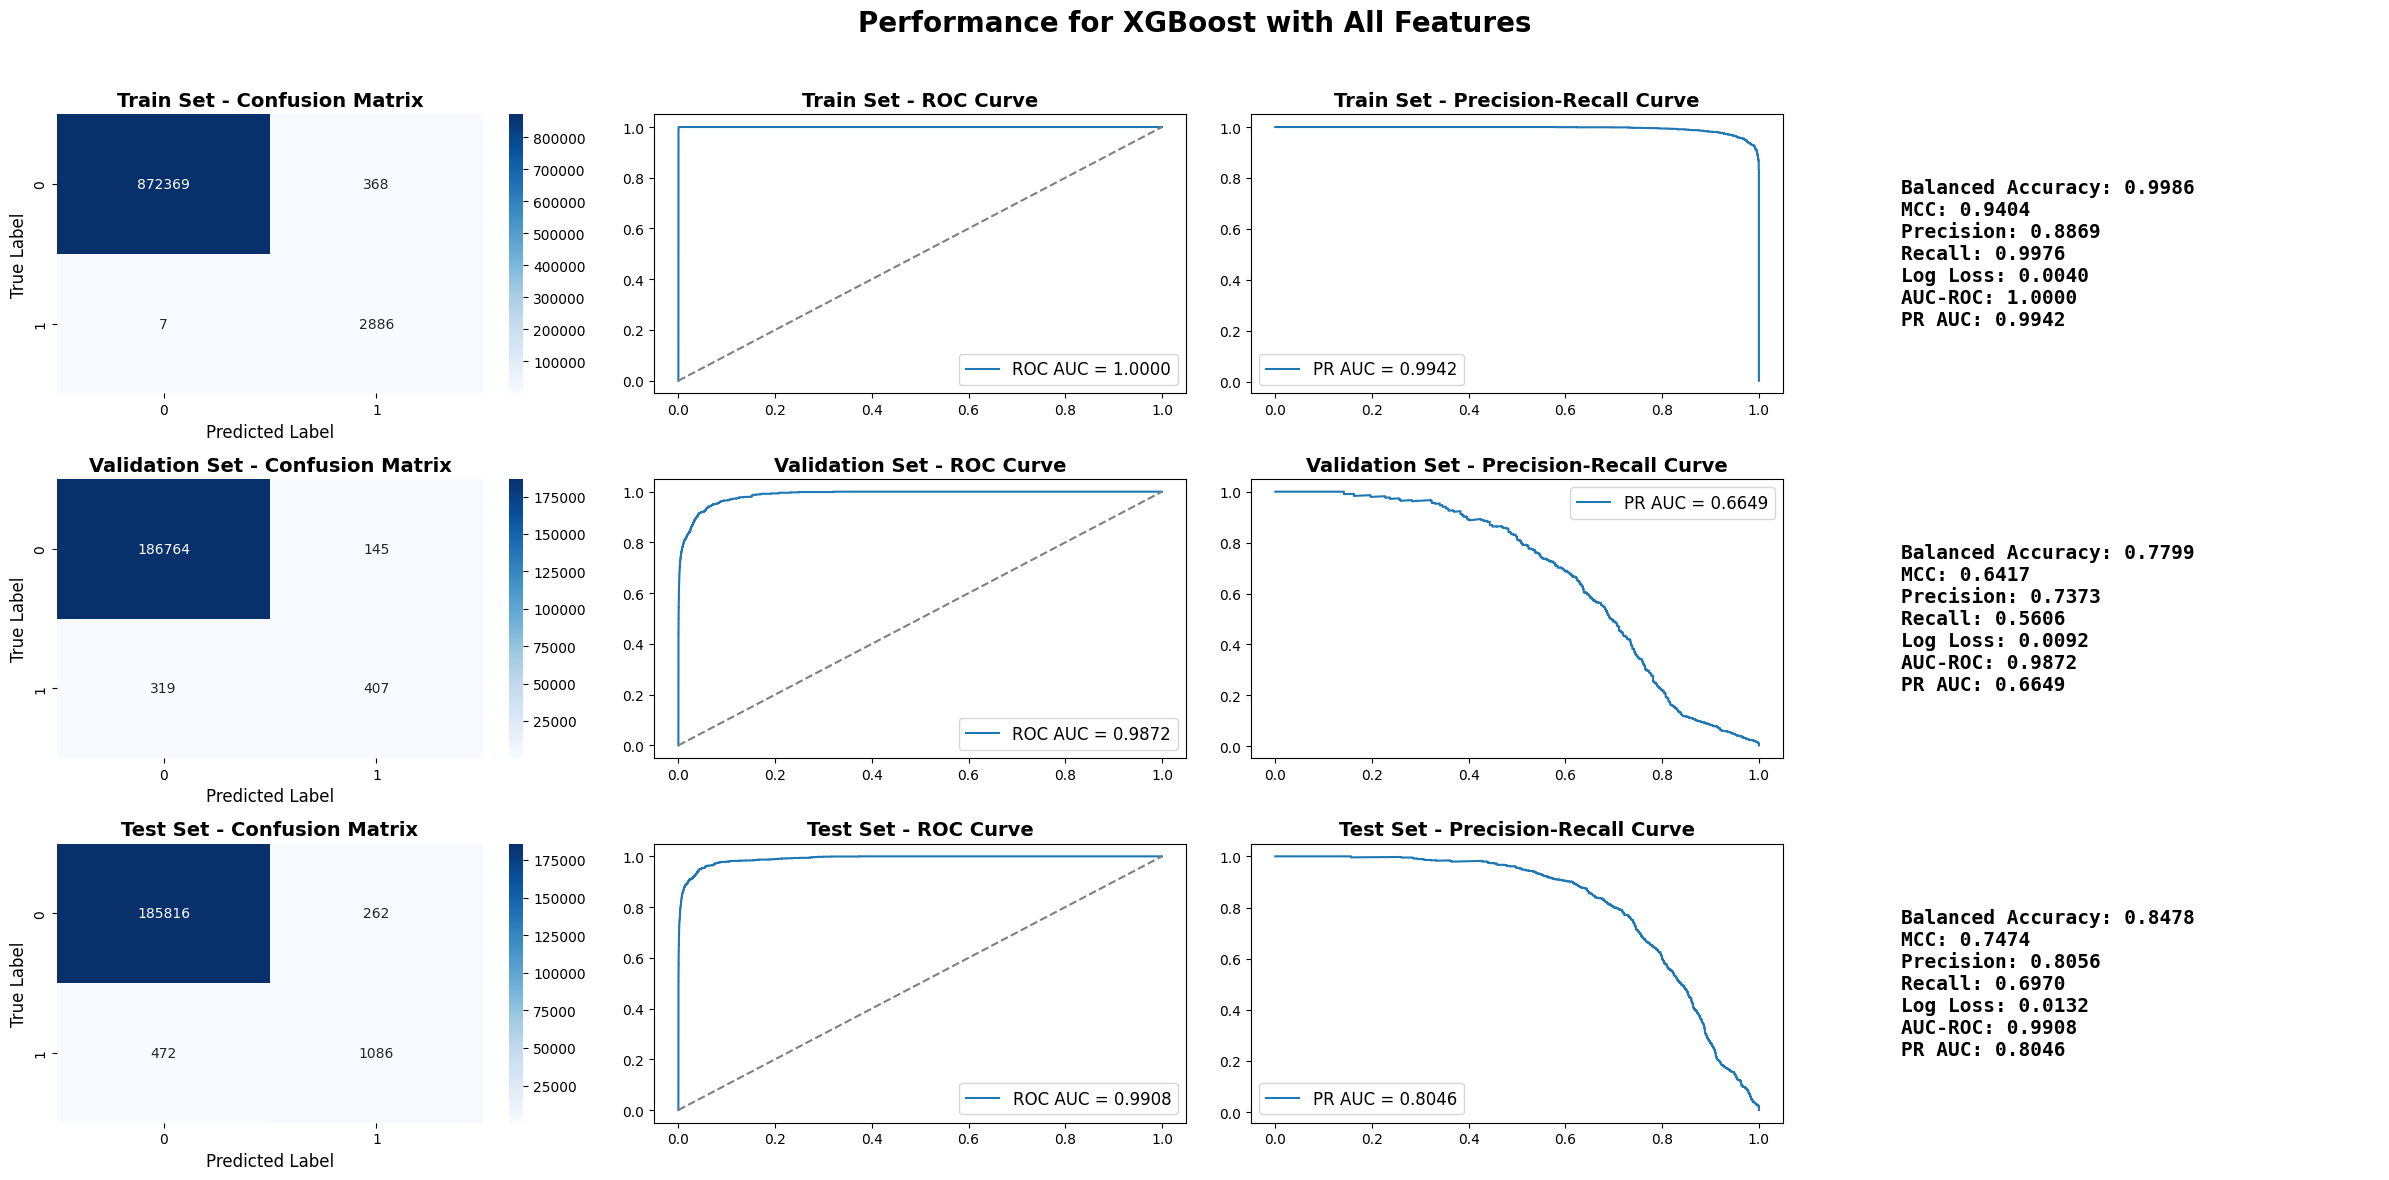

In [7]:
import xgboost as xgb

# 1) Instantiate an XGBClassifier—mirror your CatBoost settings as closely as possible:
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,         # allow more trees, we'll stop early
    max_depth=4,               # shallower trees → less variance
    learning_rate=0.03,        # smaller step size
    objective='binary:logistic',
    scale_pos_weight=12,       # keep your class‐imbalance weight
    subsample=0.6,             # each tree sees 80% of the rows
    colsample_bytree=0.6,      # each tree sees 80% of the columns
    reg_alpha=5.0,             # L1 regularization
    reg_lambda=5.0,            # L2 regularization
    random_state=42,
    eval_metric='aucpr',
    early_stopping_rounds=50  # monitor PR-AUC
)

# 2) Fit with early stopping on your validation split:
xgb_model.fit(
    mp.X_train, mp.y_train,
    eval_set=[(mp.X_val, mp.y_val)],
    verbose=100
)

# 3) Get probabilities & 0.5‐threshold predictions:
train_proba = xgb_model.predict_proba(mp.X_train)[:, 1]
val_proba   = xgb_model.predict_proba(mp.X_val)[:, 1]
test_proba  = xgb_model.predict_proba(mp.X_test)[:, 1]

train_pred = (train_proba > 0.5).astype(int)
val_pred   = (val_proba   > 0.5).astype(int)
test_pred  = (test_proba  > 0.5).astype(int)

from plotting.result_metrics import result_metrics
# 6) Finally, re-use your 3×4 plotting helper:
slide_title = "Performance for XGBoost with All Features"
result_metrics(
    slide_title,
    mp.y_train, train_pred, train_proba,
    mp.y_val,   val_pred,   val_proba,
    mp.y_test,  test_pred,  test_proba,
    class_labels=["Licit", "Illicit"]
)

# Feature Selection

In [9]:
# 3) Run the full feature‐selection + training pipeline
out = mp.feature_selection_pipeline(
    xgb_model    = xgb_model,
    top_n        = 3,   # pick top-3 per group from SHAP
    min_features = 10   # prune down to 10 features in backward pass
)

▶ Top 3 ‘currencies sent’ by |SHAP|:
                        feature  mean_abs_shap
sent_currency_Australian Dollar       0.059542
          sent_currency_Bitcoin       0.051023
      sent_currency_Brazil Real       0.049820

▶ Top 3 ‘currencies received’ by |SHAP|:
                            feature  mean_abs_shap
received_currency_Australian Dollar       0.148816
          received_currency_Bitcoin       0.144238
      received_currency_Brazil Real       0.125148

▶ Top 3 ‘payment types’ by |SHAP|:
             feature  mean_abs_shap
    payment_type_ACH       0.231168
payment_type_Bitcoin       0.224796
   payment_type_Cash       0.205026
all_onehots  →  F1 = 0.6187,  PR-AUC = 0.6746
no_sent      →  F1 = 0.6197,  PR-AUC = 0.6813
no_received  →  F1 = 0.6155,  PR-AUC = 0.6739
no_currency  →  F1 = 0.6299,  PR-AUC = 0.6753
top3_all     →  F1 = 0.6209,  PR-AUC = 0.6723
top3_payment_only →  F1 = 0.6281,  PR-AUC = 0.6836
Trying drop is_weekend: PR‐AUC = 0.6335
✅ Removed is_weekend; new be

# Results

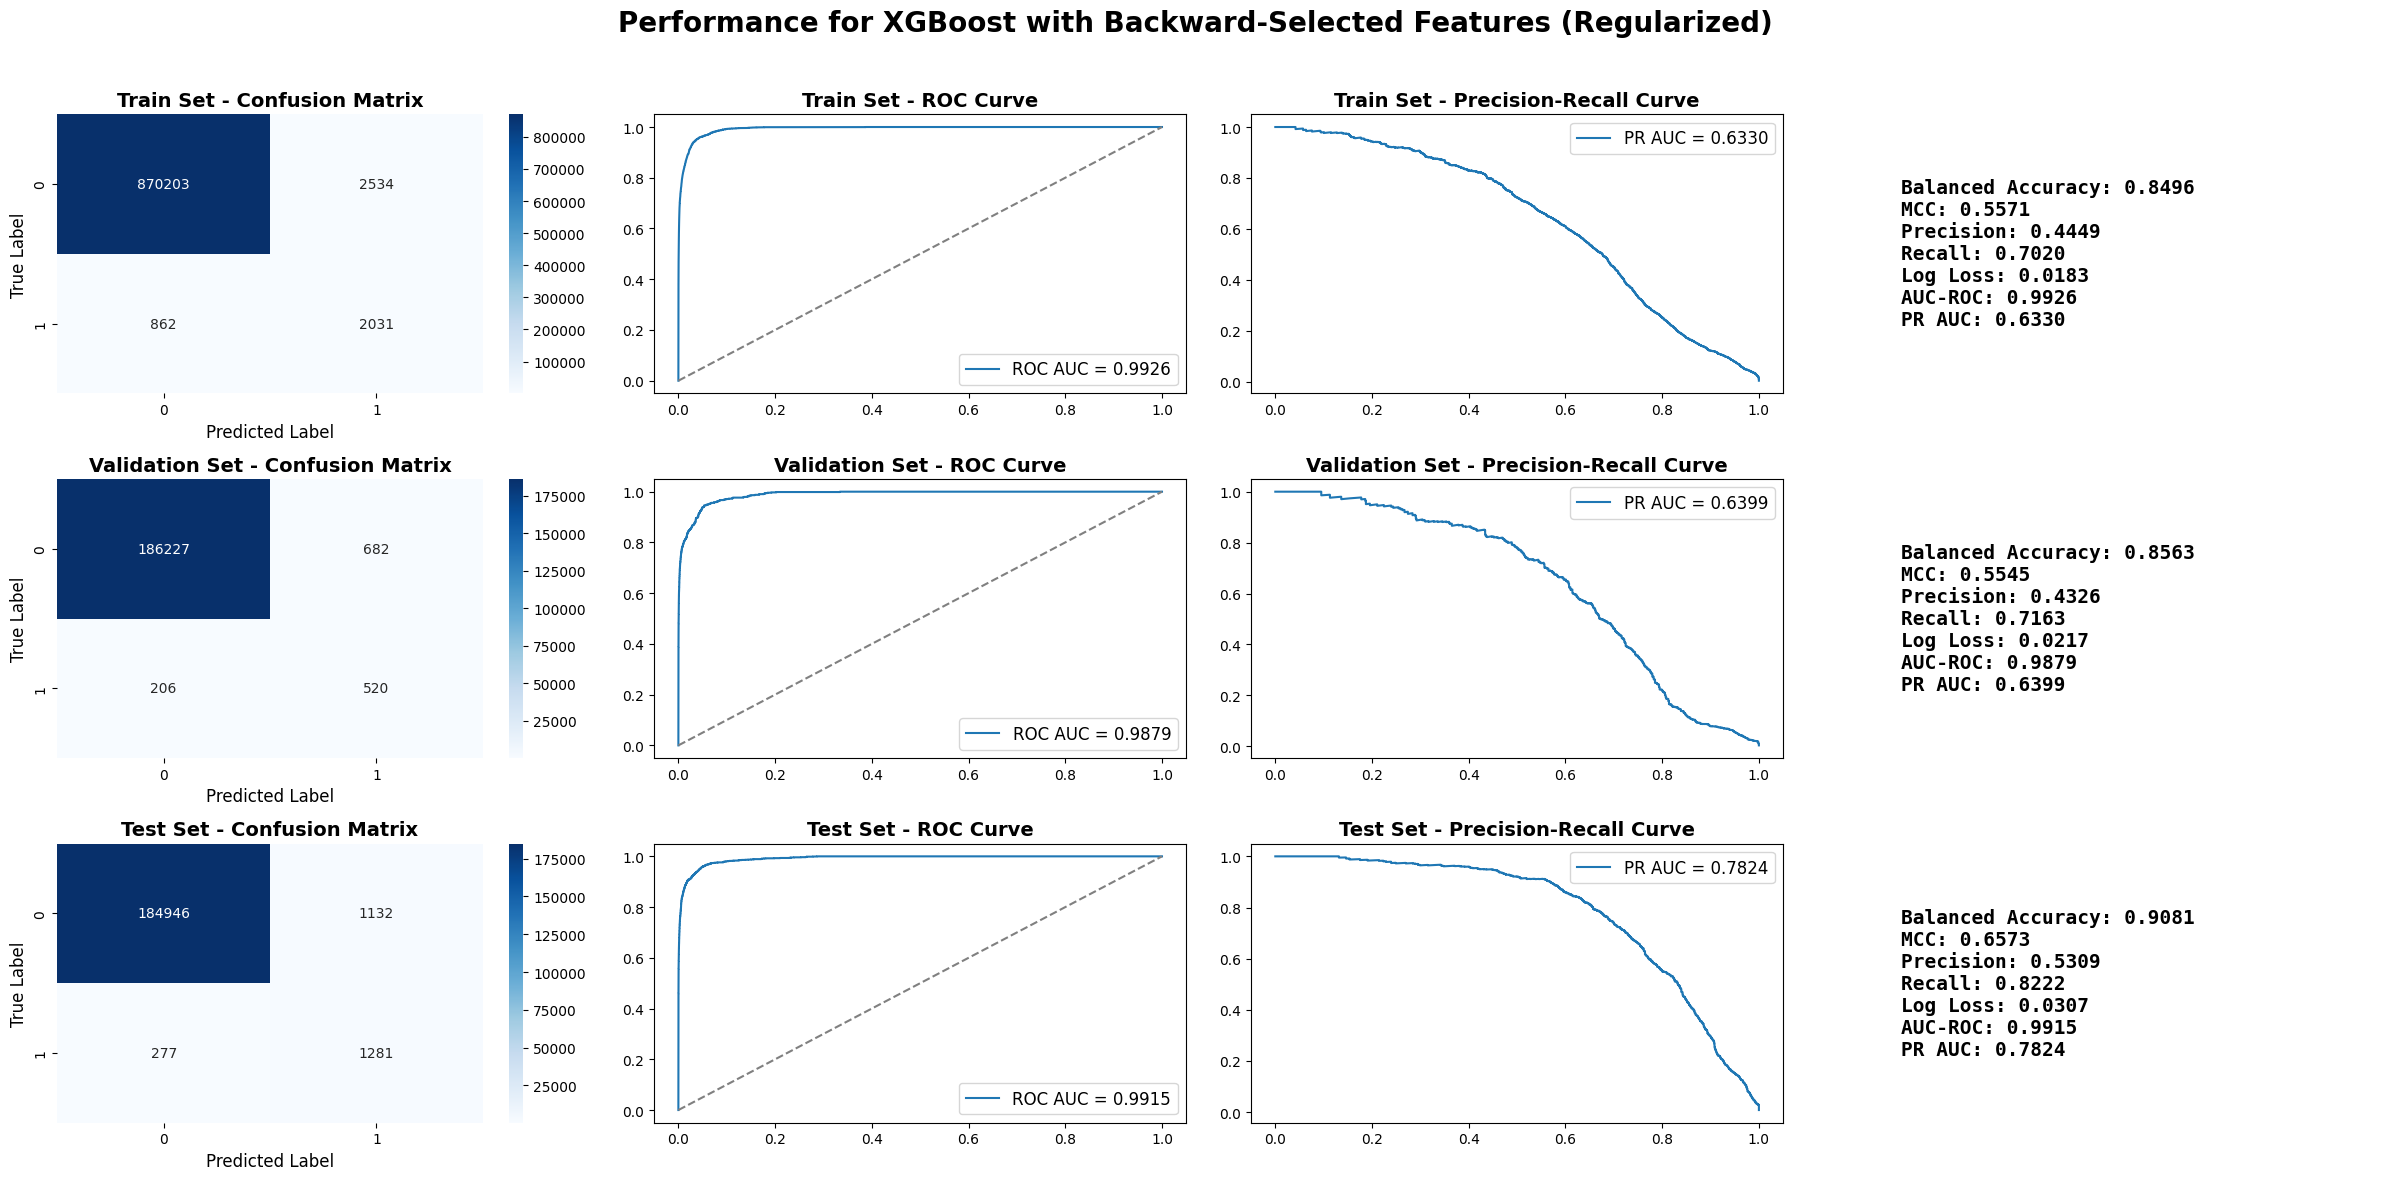

In [14]:
xgb_model = out["final_model"]
selected_features = out["selected_features"]

# 3) Score & plot
train_proba = xgb_model.predict_proba(mp.X_train[selected_features])[:, 1]
val_proba   = xgb_model.predict_proba(mp.X_val[selected_features])[:,   1]
test_proba  = xgb_model.predict_proba(mp.X_test[selected_features])[:,  1]

train_pred = (train_proba > 0.5).astype(int)
val_pred   = (val_proba   > 0.5).astype(int)
test_pred  = (test_proba  > 0.5).astype(int)

slide_title = "Performance for XGBoost with Backward-Selected Features (Regularized)"
result_metrics(
    slide_title,
    mp.y_train, train_pred, train_proba,
    mp.y_val,   val_pred,   val_proba,
    mp.y_test,  test_pred,  test_proba,
    class_labels=["Licit", "Illicit"]
)